In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all='ignore')

cars_LinearRegression = pd.read_parquet("cars_ready_LinearRegression_small.parquet")
print("Price" in cars_LinearRegression.columns)
print(cars_LinearRegression.columns.tolist())

cars_DecisionTree = pd.read_parquet("cars_ready_DecisionTree_small.parquet")
print("Price" in cars_DecisionTree.columns)
print(cars_DecisionTree.columns.tolist())

cars_BART = pd.read_parquet("cars_ready_BART.parquet")
print("Price" in cars_BART.columns)
print(cars_BART.columns.tolist())

False
['Mileage', 'Log_Mileage', 'Age', 'Log_Age', 'Mileage_per_Year', 'Engine_Power', 'Engine_Capacity', 'Power_per_Liter', 'No_Accidents', 'Service_Record', 'Is_Imported', 'First_Owner', 'Professional_Seller', 'Make_Aixam', 'Make_Alfa Romeo', 'Make_Audi', 'Make_Baic', 'Make_Bentley', 'Make_Bmw', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroën', 'Make_Cupra', 'Make_Dacia', 'Make_Daihatsu', 'Make_Dodge', 'Make_Ds Automobiles', 'Make_Fiat', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Isuzu', 'Make_Iveco', 'Make_Jaecoo', 'Make_Jaguar', 'Make_Jeep', 'Make_Kia', 'Make_Lamborghini', 'Make_Lancia', 'Make_Land Rover', 'Make_Lexus', 'Make_Maserati', 'Make_Mazda', 'Make_Mercedes-Benz', 'Make_Mg', 'Make_Mini', 'Make_Mitsubishi', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Ram', 'Make_Renault', 'Make_Saab', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong/Kgm', 'Make_Subaru', 'Make_Suzuki', 'Make_Tesla', 'Make_Toyota', 'Make_Vo

In [2]:
from sklearn.preprocessing import StandardScaler

df = cars_DecisionTree.copy()
train_df = df[df["cv_fold"] != -1].copy()
test_df = df[df["cv_fold"] == -1].copy()

continuous_features = [
    col for col in df.columns
    if col.startswith("desc_pca_") or col in [
        'Mileage', 'Log_Mileage', 'Age', 'Log_Age',
        'Mileage_per_Year', 'Engine_Power',
        'Engine_Capacity', 'Power_per_Liter'
    ]
]
categorical_features = [
    col for col in df.columns
    if col not in continuous_features + ['Log_Price', 'Price', 'cv_fold', 'split']
]

train_df = train_df.dropna(subset=continuous_features)
test_df = test_df.dropna(subset=continuous_features)

X_train_cont = train_df[continuous_features].astype(np.float32)
X_test_cont = test_df[continuous_features].astype(np.float32)
X_train_cat = train_df[categorical_features].astype(np.float32)
X_test_cat = test_df[categorical_features].astype(np.float32)

scaler = StandardScaler()
X_train_cont_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont), columns=X_train_cont.columns, index=X_train_cont.index)
X_test_cont_scaled = pd.DataFrame(scaler.transform(X_test_cont), columns=X_test_cont.columns, index=X_test_cont.index)

X_train_struct = pd.concat([X_train_cont_scaled, X_train_cat], axis=1)
X_test_struct = pd.concat([X_test_cont_scaled, X_test_cat], axis=1)

y_train = train_df["Log_Price"]
y_test = test_df["Log_Price"]

print(f"✅ Structural input shape: {X_train_struct.shape}")

✅ Structural input shape: (165236, 119)


In [3]:
# Zakładamy, że embeddings są już zredukowane PCA w kolumnach `desc_pca_0` ... `desc_pca_49`
text_features = [col for col in cars_DecisionTree.columns if col.startswith("desc_pca_")]

X_train_text = train_df[text_features].astype(np.float32)
X_test_text = test_df[text_features].astype(np.float32)

print(f"✅ Text input shape: {X_train_text.shape}")

✅ Text input shape: (165236, 50)


In [4]:
import torch
from torch import nn

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], dropout=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.LayerNorm(hidden_dims[0]),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 1)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

BATCH_SIZE = 1024
EPOCHS = 50
PATIENCE = 5
LR = 1e-3

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

cv_mae, cv_rmse, cv_r2 = [], [], []
all_mae_curves = []
mae_fold1 = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_struct)):
    print(f"\n🔁 Fold {fold+1}/5")

    X_train_s = torch.tensor(X_train_struct.iloc[train_idx].values, dtype=torch.float32).to(DEVICE)
    X_val_s = torch.tensor(X_train_struct.iloc[val_idx].values, dtype=torch.float32).to(DEVICE)
    X_train_t = torch.tensor(X_train_text.iloc[train_idx].values, dtype=torch.float32).to(DEVICE)
    X_val_t = torch.tensor(X_train_text.iloc[val_idx].values, dtype=torch.float32).to(DEVICE)
    y_train_f = torch.tensor(y_train.iloc[train_idx].values.reshape(-1, 1), dtype=torch.float32).to(DEVICE)
    y_val_f = torch.tensor(y_train.iloc[val_idx].values.reshape(-1, 1), dtype=torch.float32).to(DEVICE)

    train_loader_s = DataLoader(TensorDataset(X_train_s, y_train_f), batch_size=BATCH_SIZE, shuffle=True)
    val_loader_s = DataLoader(TensorDataset(X_val_s, y_val_f), batch_size=BATCH_SIZE)
    train_loader_t = DataLoader(TensorDataset(X_train_t, y_train_f), batch_size=BATCH_SIZE, shuffle=True)
    val_loader_t = DataLoader(TensorDataset(X_val_t, y_val_f), batch_size=BATCH_SIZE)

    model_s = SimpleMLP(X_train_s.shape[1]).to(DEVICE)
    model_t = SimpleMLP(X_train_t.shape[1]).to(DEVICE)
    opt_s = torch.optim.Adam(model_s.parameters(), lr=LR)
    opt_t = torch.optim.Adam(model_t.parameters(), lr=LR)
    crit = nn.MSELoss()

    best_rmse = float("inf")
    wait = 0
    mae_per_epoch = []

    for epoch in range(EPOCHS):
        model_s.train()
        model_t.train()

        for (xb_s, yb), (xb_t, _) in zip(train_loader_s, train_loader_t):
            opt_s.zero_grad()
            opt_t.zero_grad()
            out_s = model_s(xb_s)
            out_t = model_t(xb_t)
            out = 0.5 * out_s + 0.5 * out_t
            loss = crit(out, yb)
            loss.backward()
            opt_s.step()
            opt_t.step()

        model_s.eval()
        model_t.eval()
        preds, targets = [], []
        with torch.no_grad():
            for (xb_s, yb), (xb_t, _) in zip(val_loader_s, val_loader_t):
                out_s = model_s(xb_s)
                out_t = model_t(xb_t)
                out = 0.5 * out_s + 0.5 * out_t
                preds.append(out.cpu().numpy())
                targets.append(yb.cpu().numpy())

        preds = np.vstack(preds)
        targets = np.vstack(targets)

        rmse = np.sqrt(mean_squared_error(targets, preds))
        mae = mean_absolute_error(targets, preds)
        r2 = r2_score(targets, preds)
        mae_per_epoch.append(mae)

        print(f"Epoch {epoch+1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_mae = mae
            best_r2 = r2
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print("⏹️ Early stopping")
                break

    cv_mae.append(best_mae)
    cv_rmse.append(best_rmse)
    cv_r2.append(best_r2)
    all_mae_curves.append(mae_per_epoch)
    if fold == 0:
        mae_fold1 = mae_per_epoch.copy()

Using device: mps

🔁 Fold 1/5
Epoch 1: RMSE = 0.3965, MAE = 0.2922
Epoch 2: RMSE = 0.3606, MAE = 0.2700
Epoch 3: RMSE = 0.3209, MAE = 0.2326
Epoch 4: RMSE = 0.3130, MAE = 0.2269
Epoch 5: RMSE = 0.3409, MAE = 0.2591
Epoch 6: RMSE = 0.3176, MAE = 0.2374
Epoch 7: RMSE = 0.3009, MAE = 0.2209
Epoch 8: RMSE = 0.2884, MAE = 0.2085
Epoch 9: RMSE = 0.3025, MAE = 0.2257
Epoch 10: RMSE = 0.2858, MAE = 0.2089
Epoch 11: RMSE = 0.2704, MAE = 0.1932
Epoch 12: RMSE = 0.2775, MAE = 0.2023
Epoch 13: RMSE = 0.2677, MAE = 0.1939
Epoch 14: RMSE = 0.2596, MAE = 0.1866
Epoch 15: RMSE = 0.3343, MAE = 0.2671
Epoch 16: RMSE = 0.3105, MAE = 0.2427
Epoch 17: RMSE = 0.2590, MAE = 0.1864
Epoch 18: RMSE = 0.2623, MAE = 0.1881
Epoch 19: RMSE = 0.2572, MAE = 0.1840
Epoch 20: RMSE = 0.2541, MAE = 0.1809
Epoch 21: RMSE = 0.2610, MAE = 0.1894
Epoch 22: RMSE = 0.3202, MAE = 0.2500
Epoch 23: RMSE = 0.3265, MAE = 0.2622
Epoch 24: RMSE = 0.2471, MAE = 0.1761
Epoch 25: RMSE = 0.2950, MAE = 0.2276
Epoch 26: RMSE = 0.2524, MAE 

In [8]:
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Konwersja z DataFrame na NumPy → tensor
X_struct_tensor = torch.tensor(X_train_struct.values, dtype=torch.float32).to(DEVICE)
X_text_tensor = torch.tensor(X_train_text.values, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32).to(DEVICE)

# Podział train/val
val_size = int(0.1 * len(X_struct_tensor))
train_size = len(X_struct_tensor) - val_size
train_ds, val_ds = random_split(
    TensorDataset(X_struct_tensor, X_text_tensor, y_tensor),
    [train_size, val_size]
)

# Osobne loadery dla każdej modalności (z zachowaniem indeksów)
train_loader_s = DataLoader(
    TensorDataset(X_struct_tensor[train_ds.indices], y_tensor[train_ds.indices]),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader_s = DataLoader(
    TensorDataset(X_struct_tensor[val_ds.indices], y_tensor[val_ds.indices]),
    batch_size=BATCH_SIZE
)

train_loader_t = DataLoader(
    TensorDataset(X_text_tensor[train_ds.indices], y_tensor[train_ds.indices]),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader_t = DataLoader(
    TensorDataset(X_text_tensor[val_ds.indices], y_tensor[val_ds.indices]),
    batch_size=BATCH_SIZE
)

# Inicjalizacja modeli
model_s_final = SimpleMLP(X_struct_tensor.shape[1]).to(DEVICE)
model_t_final = SimpleMLP(X_text_tensor.shape[1]).to(DEVICE)
opt_s = torch.optim.Adam(model_s_final.parameters(), lr=LR)
opt_t = torch.optim.Adam(model_t_final.parameters(), lr=LR)
crit = nn.MSELoss()

best_loss = float("inf")
wait = 0

print("\n🚀 Final training with early stopping...")
for epoch in range(EPOCHS):
    model_s_final.train()
    model_t_final.train()
    for (xb_s, yb), (xb_t, _) in zip(train_loader_s, train_loader_t):
        opt_s.zero_grad()
        opt_t.zero_grad()

        out_s = model_s_final(xb_s)
        out_t = model_t_final(xb_t)
        out = 0.5 * out_s + 0.5 * out_t

        loss = crit(out, yb)
        loss.backward()
        opt_s.step()
        opt_t.step()

    # Walidacja
    model_s_final.eval()
    model_t_final.eval()
    val_losses = []
    with torch.no_grad():
        for (xb_s, yb), (xb_t, _) in zip(val_loader_s, val_loader_t):
            out_s = model_s_final(xb_s)
            out_t = model_t_final(xb_t)
            out = 0.5 * out_s + 0.5 * out_t
            val_losses.append(crit(out, yb).item())
    val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_state_s = model_s_final.state_dict()
        best_state_t = model_t_final.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# Wczytanie najlepszego stanu
model_s_final.load_state_dict(best_state_s)
model_t_final.load_state_dict(best_state_t)


🚀 Final training with early stopping...
Epoch 1: Val Loss = 0.1439
Epoch 2: Val Loss = 0.1177
Epoch 3: Val Loss = 0.1054
Epoch 4: Val Loss = 0.1099
Epoch 5: Val Loss = 0.0991
Epoch 6: Val Loss = 0.0885
Epoch 7: Val Loss = 0.0838
Epoch 8: Val Loss = 0.0846
Epoch 9: Val Loss = 0.0822
Epoch 10: Val Loss = 0.0742
Epoch 11: Val Loss = 0.0753
Epoch 12: Val Loss = 0.0740
Epoch 13: Val Loss = 0.0704
Epoch 14: Val Loss = 0.0682
Epoch 15: Val Loss = 0.0663
Epoch 16: Val Loss = 0.0672
Epoch 17: Val Loss = 0.0770
Epoch 18: Val Loss = 0.0617
Epoch 19: Val Loss = 0.0722
Epoch 20: Val Loss = 0.0651
Epoch 21: Val Loss = 0.0646
Epoch 22: Val Loss = 0.0842
Epoch 23: Val Loss = 0.0715
⏹️ Early stopping triggered.


<All keys matched successfully>

In [10]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

# Konwersja danych testowych do tensora
X_test_struct_tensor = torch.tensor(X_test_struct.values, dtype=torch.float32).to(DEVICE)
X_test_text_tensor = torch.tensor(X_test_text.values, dtype=torch.float32).to(DEVICE)
y_test_array = y_test.values  # numpy array

# Predykcja (Late Fusion: średnia predykcji dwóch modeli)
model_s_final.eval()
model_t_final.eval()

with torch.no_grad():
    y_pred_struct = model_s_final(X_test_struct_tensor).cpu().numpy().flatten()
    y_pred_text = model_t_final(X_test_text_tensor).cpu().numpy().flatten()
    y_pred_test = 0.5 * y_pred_struct + 0.5 * y_pred_text

# Oblicz metryki
mae_test = mean_absolute_error(y_test_array, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_array, y_pred_test))
r2_test = r2_score(y_test_array, y_pred_test)

# Podsumowanie
fusion_results = pd.DataFrame({
    "MAE_CV": [np.mean(cv_mae)],
    "RMSE_CV": [np.mean(cv_rmse)],
    "R2_CV": [np.mean(cv_r2)],
    "MAE_Test": [mae_test],
    "RMSE_Test": [rmse_test],
    "R2_Test": [r2_test]
}, index=["LateFusion"]).round(4)

print("\n📊 Late Fusion Cross-validation and test set performance:")
print(tabulate(fusion_results, headers="keys", tablefmt="github"))


📊 Late Fusion Cross-validation and test set performance:
|            |   MAE_CV |   RMSE_CV |   R2_CV |   MAE_Test |   RMSE_Test |   R2_Test |
|------------|----------|-----------|---------|------------|-------------|-----------|
| LateFusion |    0.182 |    0.2552 |  0.9242 |     0.2002 |       0.267 |    0.9171 |


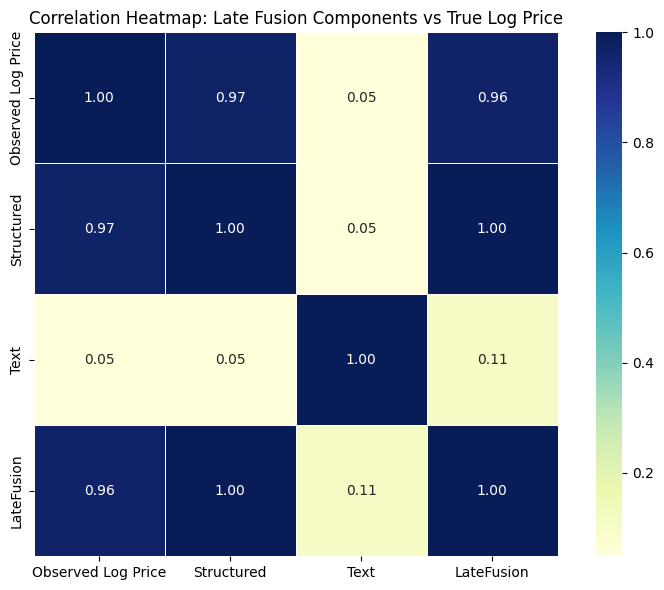

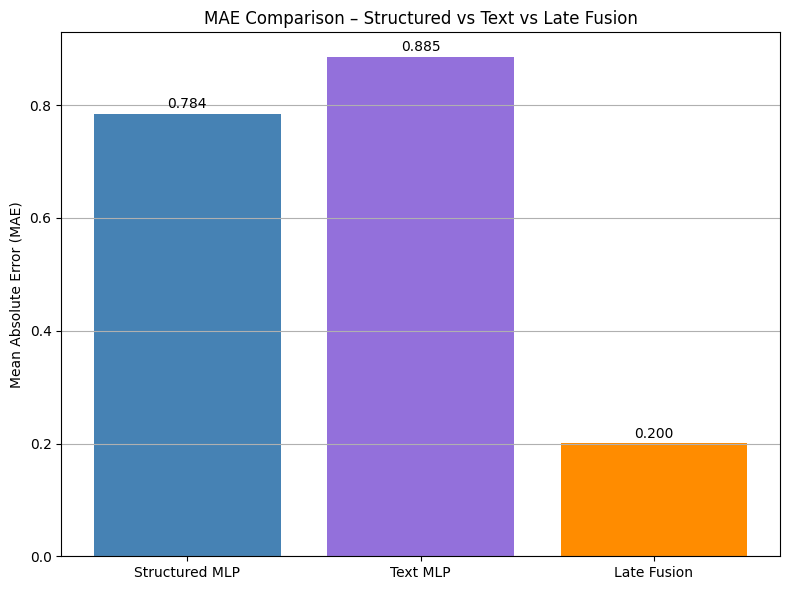

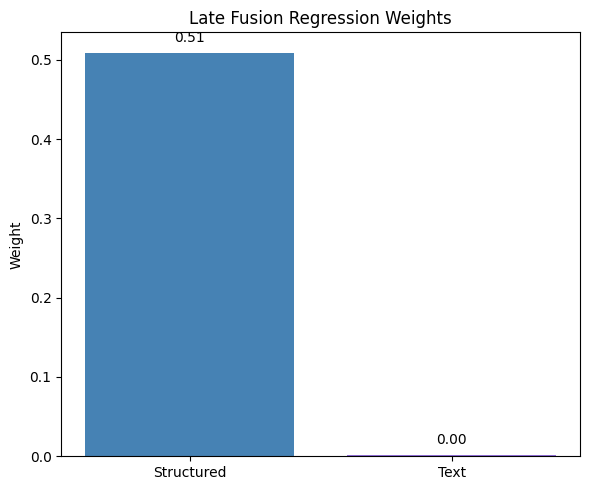

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1. Heatmapa korelacji predykcji (najlepszy wykres do interpretacji modalności) ===
df_corr = pd.DataFrame({
    "Observed Log Price": y_test_array,
    "Structured": y_pred_struct,
    "Text": y_pred_text,
    "LateFusion": y_pred_test
})
corr_matrix = df_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True, linewidths=0.5)
plt.title("Correlation Heatmap: Late Fusion Components vs True Log Price")
plt.tight_layout()
plt.show()

# === 2. Porównanie MAE między komponentami a fuzją ===
mae_struct = mean_absolute_error(y_test_array, y_pred_struct)
mae_text = mean_absolute_error(y_test_array, y_pred_text)
mae_fusion = mean_absolute_error(y_test_array, y_pred_test)

plt.figure(figsize=(8, 6))
bars = plt.bar(["Structured MLP", "Text MLP", "Late Fusion"],
               [mae_struct, mae_text, mae_fusion],
               color=["steelblue", "mediumpurple", "darkorange"])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom')
plt.title("MAE Comparison – Structured vs Text vs Late Fusion")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === 3. Wagi regresji łączącej (jeśli Late Fusion to linear combination) ===
X_fusion = np.vstack([y_pred_struct, y_pred_text]).T
reg = LinearRegression().fit(X_fusion, y_test_array)
weights = reg.coef_

plt.figure(figsize=(6, 5))
bars = plt.bar(["Structured", "Text"], weights, color=["steelblue", "mediumpurple"])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom')
plt.title("Late Fusion Regression Weights")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

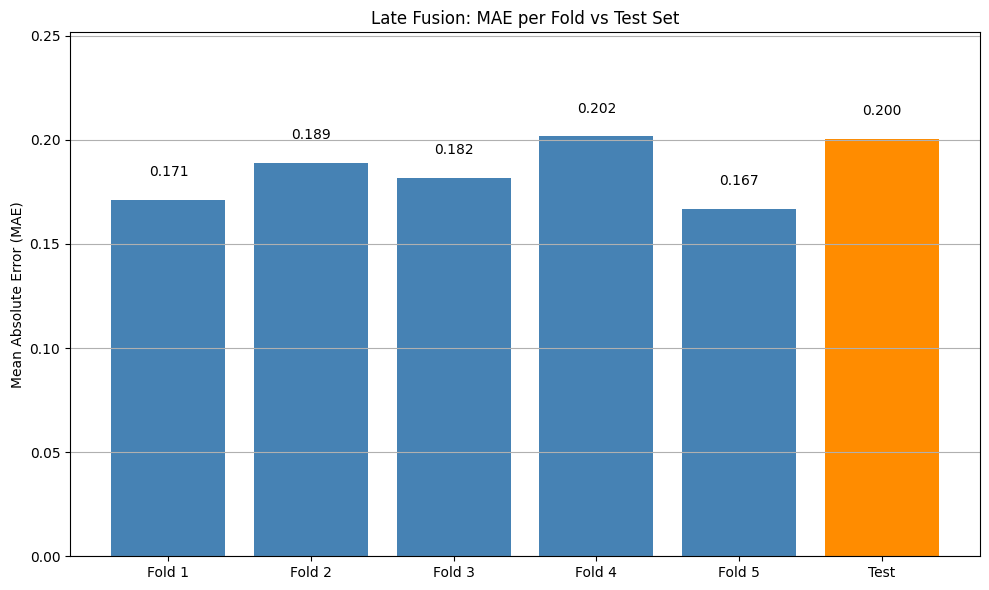

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.bar([f"Fold {i+1}" for i in range(len(cv_mae))] + ["Test"],
               cv_mae + [mae_test],
               color=["steelblue"] * len(cv_mae) + ["darkorange"])
plt.title("Late Fusion: MAE per Fold vs Test Set")
plt.ylabel("Mean Absolute Error (MAE)")
plt.ylim(0, max(cv_mae + [mae_test]) + 0.05)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

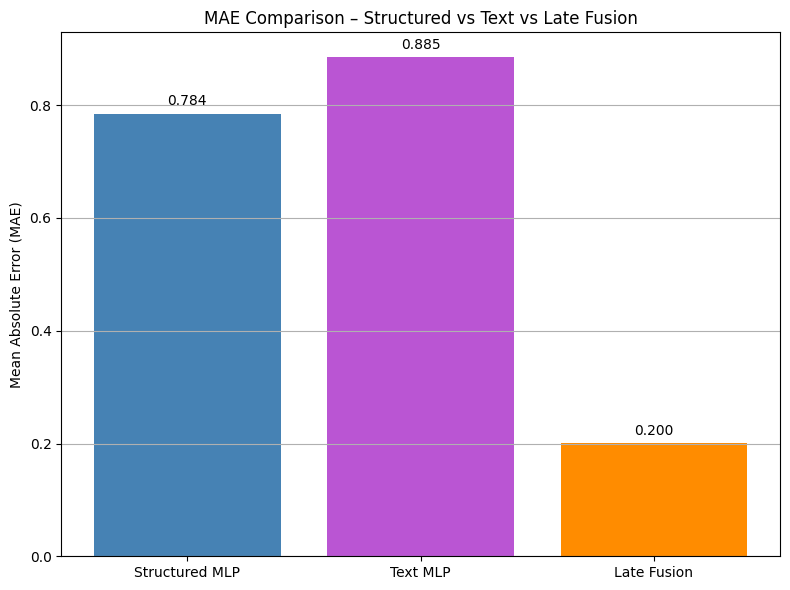

In [13]:
mae_struct = mean_absolute_error(y_test, y_pred_struct)
mae_text = mean_absolute_error(y_test, y_pred_text)

plt.figure(figsize=(8, 6))
bars = plt.bar(["Structured MLP", "Text MLP", "Late Fusion"],
               [mae_struct, mae_text, mae_test],
               color=["steelblue", "mediumorchid", "darkorange"])
plt.title("MAE Comparison – Structured vs Text vs Late Fusion")
plt.ylabel("Mean Absolute Error (MAE)")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [1]:
import seaborn as sns
import pandas as pd

corr_df = pd.DataFrame({
    "Observed Log Price": y_test,
    "Structured": y_pred_struct,
    "Text": y_pred_text,
    "LateFusion": y_pred_test
})

corr = corr_df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation Heatmap: Late Fusion Components vs True Log Price")
plt.tight_layout()
plt.show()

NameError: name 'y_test' is not defined

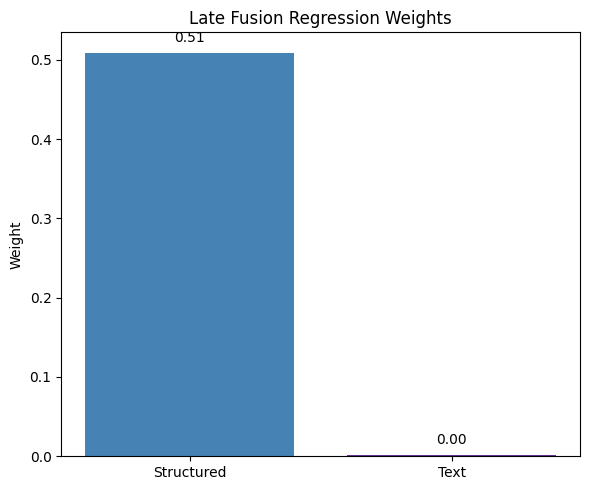

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
bars = plt.bar(["Structured", "Text"], weights, color=["steelblue", "rebeccapurple"])
plt.title("Late Fusion Regression Weights")
plt.ylabel("Weight")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()